# INTENT CLASSIFIER 

In [407]:
import pandas as pd

In [233]:
df = pd.read_csv("user_intent_classifier.csv", encoding='windows-1252')
df.head(5)

,Input Query,Intent
0,Send an email to <br/>John regarding the proje...,email_send
1,Email Alice to remind her about the <br/>docum...,email_send
2,"Send an email to (""Bob asking for the report o...",email_send
3,How many days of paid sick leave do we get eac...,knowledge_query
4,How do I submit a work order for IT support?,knowledge_query


In [234]:
print(df.shape)

(1315, 2)


In [235]:
df.duplicated().sum() 

16

In [236]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [237]:
df['Intent'].value_counts() 

Intent
knowledge_query      262
calender_schedule    261
email_send           260
general_chat         260
web_search           256
Name: count, dtype: int64

## Data Cleaning and Preprocessing Pipeline

### Removing Unwanted Characters

In [238]:
# Clean unwanted characters
df['Input Query'] = df['Input Query'].str.replace('Â', '')  # Remove unwanted characters (e.g., Â)    

###  Removing HTML Tags Using Regex

In [239]:
### Removing Tags
### Initial Text preprocesiing
### The re.sub() function replaces these matched HTML tags with an empty string, effectively removing them from the text.

import re
def remove_tags(raw_text):
    cleaned_text = re.sub(re.compile('<.*?>'), '', raw_text)
    return cleaned_text


In [240]:
df['Input Query'] = df['Input Query'].apply(remove_tags)

### Converting Text to Lowercase

In [241]:
# It ensures consistent text formatting by converting all reviews to lowercase, helping the model treat words like "Good" and "good" as the same.
df['Input Query'] = df['Input Query'].apply(lambda x:x.lower())
df.head(3)

,Input Query,Intent
0,send an email to john regarding the project up...,email_send
1,email alice to remind her about the document d...,email_send
2,"send an email to (""bob asking for the report o...",email_send


### Removing Stopwords Using NLTK

In [242]:
import nltk
from nltk.corpus import stopwords

# Download stopwords (you need to run this once)
nltk.download('stopwords')

# Load English stopwords list
sw_list = stopwords.words('english')

# Remove stopwords from 'review' column
df['Input Query'] = df['Input Query'].apply(lambda x: [item for item in x.split() if item.lower() not in sw_list]).apply(lambda x: " ".join(x))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ALI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Extracting Feature and Target Columns

In [243]:
X = df.iloc[:,0:1]  # Input 
y = df['Intent']   #  Output

### Since Target column is of Categorical type, 
### so we need to encode it before giving it to the model

In [244]:
y

0              email_send
1              email_send
2              email_send
3         knowledge_query
4         knowledge_query
              ...        
1310           web_search
1311    calender_schedule
1312           web_search
1313    calender_schedule
1314      knowledge_query
Name: Intent, Length: 1299, dtype: object

### Label Encoding of Target Classes 

In [245]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

y = encoder.fit_transform(y)

# Display class-to-number mapping
for index, label in enumerate(encoder.classes_):
    print(f"{label} --> {index}")

calender_schedule --> 0
email_send --> 1
general_chat --> 2
knowledge_query --> 3
web_search --> 4


In [246]:
y

array([1, 1, 1, ..., 4, 0, 3])

### Splitting Dataset as follows:
###   Initial Split: 80% Train, 20% Temp
###   Secondary Split: 10% Validation, 10% Test from Temp

In [162]:
# X_temp, y_temp = 20% of data
# X_val, y_val: 10% of the original data (for validation)
# X_test, y_test: 10% of the original data (for testing)

from sklearn.model_selection import train_test_split

# First split: 80% train, 20% temp
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Second split: Split 20% temp equally into 10% val and 10% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1, stratify=y_temp)


### Feature Vectorization
###    1. TF-IDF Vectorization

In [164]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

X_train_tfidf = tfidf.fit_transform(X_train['Input Query']).toarray()
X_test_tfidf = tfidf.transform(X_test['Input Query'])

### RANDOM FOREST CLASSIFIER

### Hyper parameter Tuning using GridSearchCV

In [166]:
import time

# Start the timer before training
start_time = time.time()

rf1 = RandomForestClassifier()
param_grid = {
    "n_estimators": [20, 40, 50, 70, 100,120, 150],
    "max_features": [0.2, 0.6, 1.0],
    'max_depth': [2, 8, None],
    'max_samples': [0.5, 0.75, 1.0]
}
grid = GridSearchCV(rf1, param_grid=param_grid, n_jobs=-1, verbose=2)
grid.fit(X_train_tfidf, y_train)  # You should replace X_train_tfidf, y_train with your data

# Calculate the time taken to train the model
training_time_rf = time.time() - start_time

# Print the time taken
print(f"RandomForest training time: {training_time_rf} seconds")


Fitting 5 folds for each of 189 candidates, totalling 945 fits
RandomForest training time: 294.40368247032166 seconds


### Train and Test Acuracy Scores - Random Forest

In [168]:
y_train_pred = grid.predict(X_train_tfidf)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

# Testing predictions and accuracy
y_test_pred = grid.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")

Training Accuracy: 99.69%
Testing Accuracy: 95.90%


### 2. BAG OF WORDS

In [291]:
# Applying BoW
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()

X_train_bow = cv.fit_transform(X_train['Input Query']).toarray()
X_test_bow = cv.transform(X_test['Input Query']).toarray()

### Random Forest

### Hyper parameter Tuning using GridSearchCV

In [293]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import GridSearchCV
start_time = time.time()

rf1 = RandomForestClassifier()
param_grid = {
    "n_estimators" : [20, 40 , 50, 70, 100,120,150],
    "max_features" : [0.2, 0.6 , 1.0] ,
    'max_depth': [2,8,None] , 
    'max_samples' : [0.5,0.75,1.0]
}
grid_bow = GridSearchCV ( rf1 , param_grid = param_grid , n_jobs = -1  , verbose = 2 , cv=5 )
grid_bow.fit(X_train_bow , y_train )
 
# Print the time taken
print(f"RandomForest training time: {training_time_rf} seconds")

Fitting 5 folds for each of 189 candidates, totalling 945 fits
RandomForest training time: 294.40368247032166 seconds


In [295]:
y_train_pred = grid_bow.predict(X_train_bow)
train_accuracy = accuracy_score(y_train, y_train_pred)

best_score = grid_bow.best_score_
print(f"Best cross-validation score: {best_score*100}")

print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

# Testing predictions and accuracy
y_test_pred = grid_bow.predict(X_test_bow)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")

Best cross-validation score: 95.16785619878402
Training Accuracy: 99.69%
Testing Accuracy: 95.90%


### Since the Accuracy scores using Bag of Words and TF-IDF are nearly same, hence using Bag of Words for Vectorization of other models. 

### Inference on User Input

In [335]:
# Take input from user
user_input = input("Enter a sentence: ")

# Preprocess the input (if you did lowercase/stopword removal during training, apply here too)
user_input = user_input.lower()

# Vectorize the input using the same CountVectorizer
user_input_vector = cv.transform([user_input]).toarray()

# Predict the class number
predicted_class = grid_bow.predict(user_input_vector)

# Decode the class number to original label (if you used LabelEncoder)
predicted_intent = encoder.inverse_transform(predicted_class)

# Show result
print(f"Predicted Intent: {predicted_intent[0]}")


Enter a sentence:  Can you send the proposal to the client by end of the day


Predicted Intent: web_search


### GUASSIAN NAIVE BAYES 

### Hyper parameter Tuning using GridSearchCV

In [305]:
from sklearn.naive_bayes import GaussianNB
# Define the parameter grid for var_smoothing
param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}

gnb = GaussianNB()

start_time = time.time() 

# Initialize GridSearchCV with cross-validation (e.g., 5-fold cross-validation)
grid_search_nb_bow = GridSearchCV(estimator=gnb, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search_nb_bow.fit(X_train_bow, y_train)
training_time_nb_bow = time.time() - start_time
print(f"Guassian NB training time: {training_time_nb_bow} seconds")


# Get the best hyperparameters and score from GridSearchCV
best_params = grid_search_nb_bow.best_params_
best_score = grid_search_nb_bow.best_score_

# Print the best parameters and the corresponding score
print(f"Best var_smoothing: {best_params['var_smoothing']}")
print(f"Best cross-validation score: {best_score}")

# Predict on the train set using the best model from GridSearchCV
y_train_pred = grid_search_nb_bow.predict(X_train_bow)

# Calculate train accuracy
train_accuracy = accuracy_score(y_train, y_train_pred) 

# Predict on the test set using the best model from GridSearchCV
y_test_pred = grid_search_nb_bow.predict(X_test_bow)

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the train set accuracy and test set accuracy
print(f"Train set accuracy: {train_accuracy*100}")
print(f"Test set accuracy: {test_accuracy*100}")


Guassian NB training time: 15.055447816848755 seconds
Best var_smoothing: 1e-05
Best cross-validation score: 0.9012688342585251
Train set accuracy: 96.81069958847736
Test set accuracy: 89.34426229508196


### LOGISTIC REGRESSION
### Hyper parameter Tuning using GridSearchCV

In [307]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import time

start_time = time.time() 

# Define the parameter grid for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l2'],             # Regularization type (L1 and L2)
    'solver': ['liblinear', 'saga']  # Solvers supporting L1 regularization
}

# Initialize the Logistic Regression model
log_reg = LogisticRegression()

# Initialize GridSearchCV with cross-validation (e.g., 5-fold cross-validation)
grid_search_lr_bow = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search_lr_bow.fit(X_train_bow, y_train)
training_time_lr_bow = time.time() - start_time
print(f"LR  training time: {training_time_lr_bow} seconds")


# Get the best hyperparameters and score from GridSearchCV
best_params = grid_search_lr_bow.best_params_
best_score = grid_search_lr_bow.best_score_

# Print the best parameters and the corresponding score
print(f"Best Hyperparameters: {best_params}")
print(f"Best cross-validation score: {best_score}")

# Predict on the train set using the best model from GridSearchCV
y_train_pred = grid_search_lr_bow.predict(X_train_bow)

# Calculate train accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)

# Predict on the test set using the best model from GridSearchCV
y_test_pred = grid_search_lr_bow.predict(X_test_bow)

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the train set accuracy and test set accuracy
print(f"Train set accuracy: {train_accuracy*100}")
print(f"Test set accuracy: {test_accuracy*100}")




C:\Users\ALI\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


LR  training time: 20.062429189682007 seconds
Best Hyperparameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation score: 0.9578429817605075
Train set accuracy: 96.91358024691358
Test set accuracy: 95.90163934426229


### SVM 
### Hyper parameter Tuning using GridSearchCV

In [309]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


start_time = time.time() 
# Define the parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel type
    'gamma': ['scale', 'auto'],  # Kernel coefficient (for 'rbf', 'poly', 'sigmoid')
    'degree': [3, 5],  # Degree of the polynomial kernel (only for 'poly')
    'coef0': [0, 0.5, 1]  # Independent term in kernel function (for 'poly', 'sigmoid')
}

# Initialize the SVM model
svm_model = SVC()

# Initialize GridSearchCV with cross-validation (e.g., 5-fold cross-validation)
grid_search_svm_bow = GridSearchCV(estimator=svm_model, param_grid=param_grid, n_jobs=-1, cv=5, verbose=2)

# Fit GridSearchCV to the training data
grid_search_svm_bow.fit(X_train_bow, y_train)
training_time_svm_bow = time.time() - start_time
print(f"SVM  training time: {training_time_svm_bow} seconds")

# Get the best hyperparameters and score from GridSearchCV
best_params = grid_search_svm_bow.best_params_
best_score = grid_search_svm_bow.best_score_

# Print the best parameters and the corresponding score
print(f"Best Hyperparameters: {best_params}")
print(f"Best cross-validation score: {best_score}")

# Predict on the train set using the best model from GridSearchCV
y_train_pred = grid_search_svm_bow.predict(X_train_bow)
print(f"SVM  training time: {training_time_svm_bow} seconds")

# Calculate train accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)

# Predict on the test set using the best model from GridSearchCV
y_test_pred = grid_search_svm_bow.predict(X_test_bow)

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the train set accuracy and test set accuracy
print(f"Train set accuracy: {train_accuracy}")
print(f"Test set accuracy: {test_accuracy}")


Fitting 5 folds for each of 144 candidates, totalling 720 fits
SVM  training time: 256.9452130794525 seconds
Best Hyperparameters: {'C': 100, 'coef0': 0, 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf'}
Best cross-validation score: 0.9619666931007137
SVM  training time: 256.9452130794525 seconds
Train set accuracy: 0.970164609053498
Test set accuracy: 0.9672131147540983


### Accuracy Reports of all 4 Algorithms

In [337]:
from sklearn.metrics import classification_report

# Random Forest Accuracy Report
y_train_pred_rf = grid_bow.predict(X_train_bow)
y_test_pred_rf = grid_bow.predict(X_test_bow)
print("Random Forest - Classification Report (Test Data):")
print(classification_report(y_test, y_test_pred_rf))

# Gaussian Naive Bayes Accuracy Report
y_train_pred_nb = grid_search_nb_bow.predict(X_train_bow)
y_test_pred_nb = grid_search_nb_bow.predict(X_test_bow)
print("Gaussian Naive Bayes - Classification Report (Test Data):")
print(classification_report(y_test, y_test_pred_nb))

# Logistic Regression Accuracy Report
y_train_pred_lr = grid_search_lr_bow.predict(X_train_bow)
y_test_pred_lr = grid_search_lr_bow.predict(X_test_bow)
print("Logistic Regression - Classification Report (Test Data):")
print(classification_report(y_test, y_test_pred_lr))

# SVM Accuracy Report
y_train_pred_svm = grid_search_svm_bow.predict(X_train_bow)
y_test_pred_svm = grid_search_svm_bow.predict(X_test_bow)
print("SVM - Classification Report (Test Data):")
print(classification_report(y_test, y_test_pred_svm))


Random Forest - Classification Report (Test Data):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       0.92      1.00      0.96        24
           2       1.00      0.96      0.98        26
           3       1.00      0.87      0.93        23
           4       0.89      0.96      0.93        26

    accuracy                           0.96       122
   macro avg       0.96      0.96      0.96       122
weighted avg       0.96      0.96      0.96       122

Gaussian Naive Bayes - Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        23
           1       1.00      0.88      0.93        24
           2       0.96      0.88      0.92        26
           3       0.88      0.91      0.89        23
           4       0.95      0.81      0.88        26

    accuracy                           0.89       122
   macro avg       0.9

### Confusion Matrices Visualizations

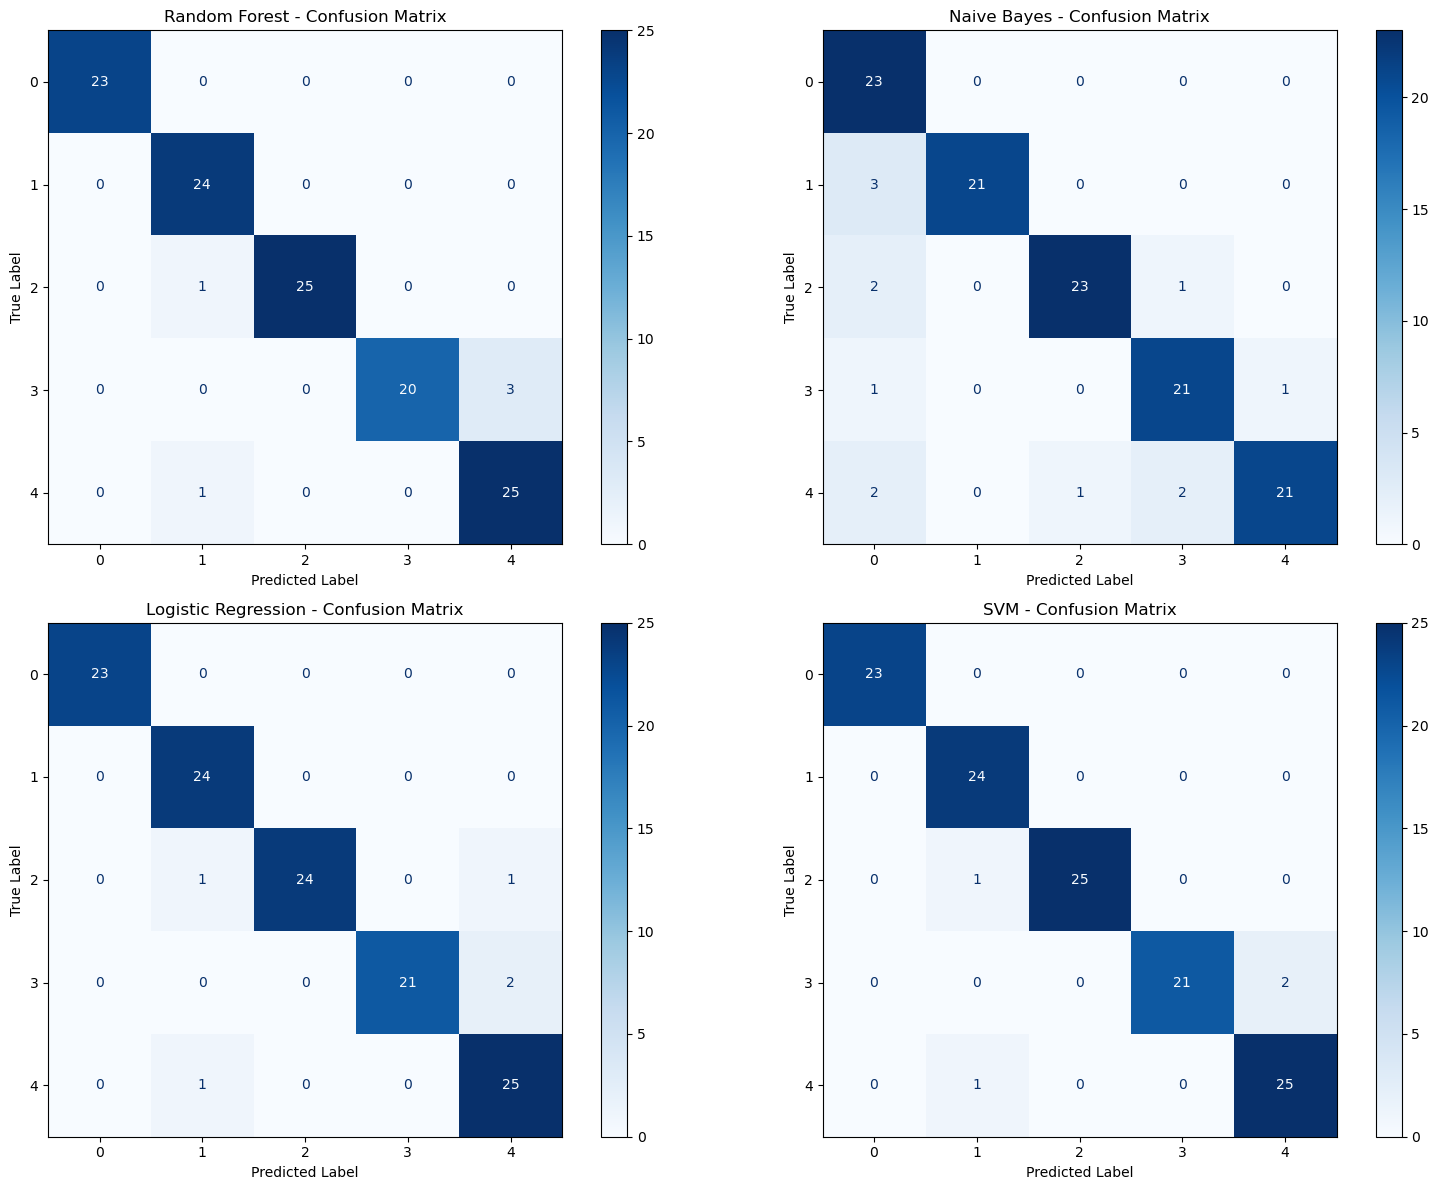

In [403]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# List of model names and their corresponding predictions
models = [
    ('Random Forest', y_test_pred_rf),
    ('Naive Bayes', y_test_pred_nb),
    ('Logistic Regression', y_test_pred_lr),
    ('SVM', y_test_pred_svm)
]

# Plot confusion matrices
plt.figure(figsize=(16, 12))

for i, (name, y_pred) in enumerate(models, 1):
    plt.subplot(2, 2, i)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=plt.gca(), cmap='Blues', values_format='d')
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

plt.tight_layout()
plt.show()


### Plots for Accuracy and Training Time Comparison 

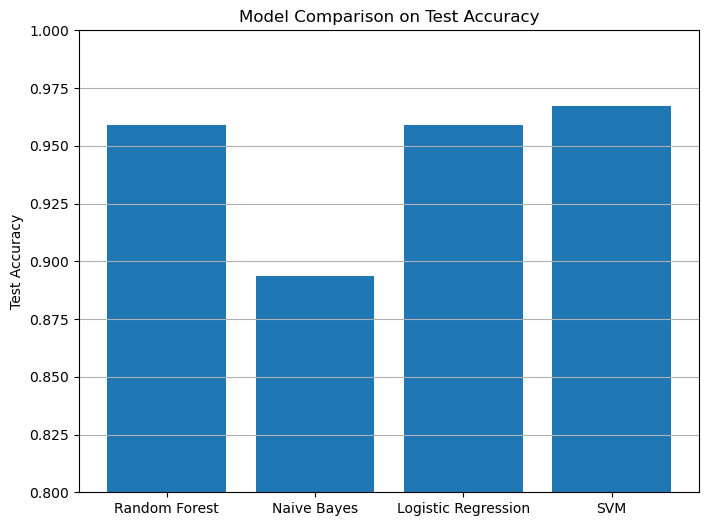

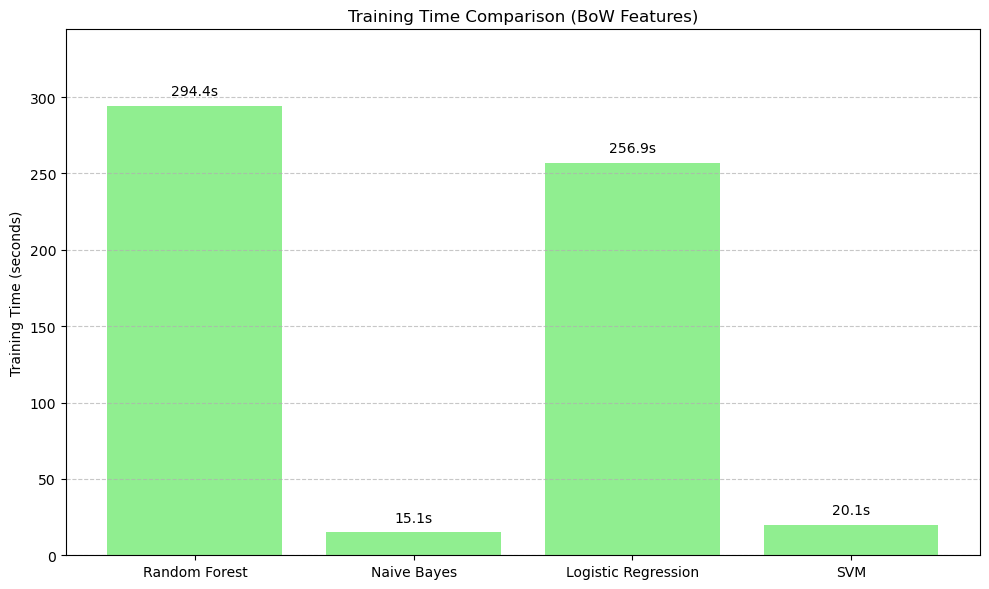

In [413]:
import matplotlib.pyplot as plt

# Replace these with your actual accuracy values if needed
rf_accuracy = accuracy_score(y_test, grid_bow.predict(X_test_bow))
nb_accuracy = accuracy_score(y_test, grid_search_nb_bow.predict(X_test_bow))
lr_accuracy = accuracy_score(y_test, grid_search_lr_bow.predict(X_test_bow))
svm_accuracy = accuracy_score(y_test, grid_search_svm_bow.predict(X_test_bow))

# Model names and accuracies
models = ['Random Forest', 'Naive Bayes', 'Logistic Regression', 'SVM']
accuracies = [rf_accuracy, nb_accuracy, lr_accuracy, svm_accuracy]

# Plot
plt.figure(figsize=(8, 6))
plt.bar(models, accuracies)
plt.ylim(0.8, 1.0)
plt.ylabel('Test Accuracy')
plt.title('Model Comparison on Test Accuracy')
plt.grid(axis='y')
plt.show()


# Actual training times (in seconds)
training_time_rf_bow = 294.40368247032166
training_time_nb_bow = 15.055447816848755
training_time_lr_bow = 20.062429189682007
training_time_svm_bow = 256.9452130794525

# Labels and data
training_times = [training_time_rf_bow, training_time_nb_bow, training_time_svm_bow , training_time_lr_bow]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(models, training_times, color='lightgreen')

# Annotate with training times
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 5, f'{height:.1f}s', ha='center', va='bottom', fontsize=10)

plt.ylabel('Training Time (seconds)')
plt.title('Training Time Comparison (BoW Features)')
plt.ylim(0, max(training_times) + 50)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()




### Since the accuracy scores and other evaluation metrics of Random Forest, Logistic Regression, and SVM are almost the same, 
### Random Forest is chosen as the final model because it not only performs well but also effectively captures non-linear patterns in the data,
### handles feature interactions, and is less sensitive to overfitting due to its ensemble nature.
### For more detail about comparison of models, kindly read the detailed PDF Report.

### Saving the Random Forest Model as Pickle file

In [420]:
# Model filename
model_filename = "model.pkl"
with open(model_filename, 'wb') as file:
    pickle.dump(grid_bow.best_estimator_, file)

# Save CountVectorizer
cv_filename = "cv.pkl"
with open(cv_filename, 'wb') as file:
    pickle.dump(cv, file)

# Save LabelEncoder
encoder_filename = "encoder.pkl"
with open(encoder_filename, 'wb') as file:
    pickle.dump(encoder, file)

print(f"Model saved as {model_filename}")
print(f"CountVectorizer saved as {cv_filename}")
print(f"LabelEncoder saved as {encoder_filename}")

Model saved as model.pkl
CountVectorizer saved as cv.pkl
LabelEncoder saved as encoder.pkl
